In [1]:
import pandas as pd
import pyvips
import os
import openslide

Define data directory

In [25]:
DATA_DIR = 'Data/'
MODE = 'DEV'

Load WSI metadata

In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
train_df

image_id label  image_width  image_height  is_tma
0           4  HGSC        23785         20008   False
1          66  LGSC        48871         48195   False
2          91  HGSC         3388          3388    True
3         281  LGSC        42309         15545   False
4         286    EC        37204         30020   False
..        ...   ...          ...           ...     ...
533     65022  LGSC        53355         46675   False
534     65094    MC        55042         45080   False
535     65300  HGSC        75860         27503   False
536     65371  HGSC        42551         41800   False
537     65533  HGSC        45190         33980   False

[538 rows x 5 columns]

Define list of png images

In [4]:
pnglist = [os.path.join(DATA_DIR, 'train_images', f'{image_id}.png') for image_id in train_df.image_id]

Check example converting from png to tif

In [5]:
image = pyvips.Image.new_from_file(f"{pnglist[0]}")

In [6]:
image

<pyvips.Image 23785x20008 uchar, 3 bands, srgb>

In [7]:
image.tiffsave(f"{pnglist[0][:-4]}.tif", tile=True, pyramid=True, bigtiff=True)

Size 1.92GB

In [18]:
wsi = openslide.OpenSlide(f"{pnglist[0][:-4]}.tif")

In [19]:
print(wsi.level_count)
print(wsi.level_dimensions)
print(wsi.level_downsamples)

9
((23785, 20008), (11892, 10004), (5946, 5002), (2973, 2501), (1486, 1250), (743, 625), (371, 312), (185, 156), (92, 78))
(1.0, 2.0000420450723175, 4.000084090144635, 8.00016818028927, 16.00622826379542, 32.01245652759084, 64.11935862879258, 128.4119889119889, 257.52271460423634)


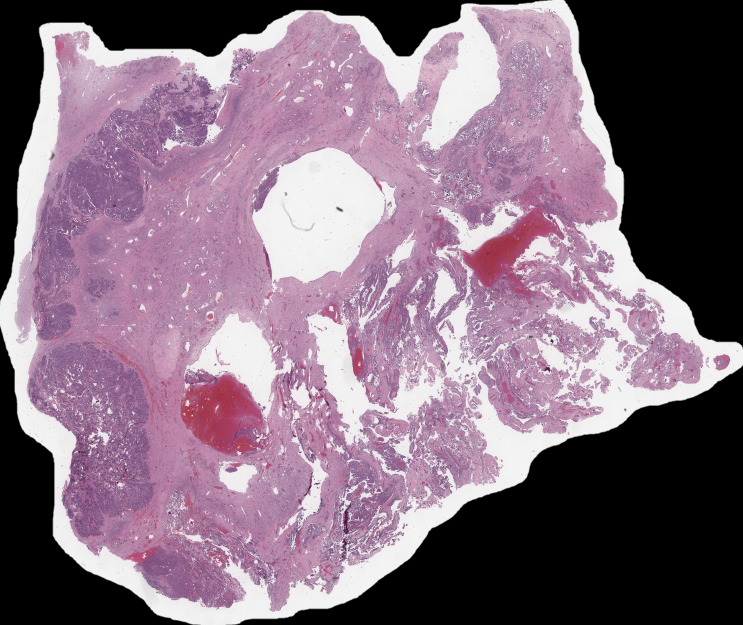

In [20]:
wsi.get_thumbnail(wsi.level_dimensions[-4])

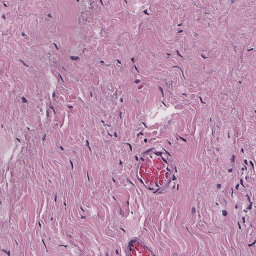

In [21]:
wsi.read_region((9000, 10000), 0, (256, 256))

### Compare sizes of different tiff files with different parameters

Documentation for savetiff: https://www.libvips.org/API/current/VipsForeignSave.html#vips-tiffsave



In [11]:
# Bigtiff is a variant of the TIFF format that allows more than 4GB in a file.
image.tiffsave(f"{pnglist[0][:-4]}_a.tif", tile=True, pyramid=True, bigtiff=False)

1.92GB

In [12]:
image.tiffsave(f"{pnglist[0][:-4]}_b.tif", tile=True, pyramid=True, bigtiff=False, 
               compression='jpeg')

113 MB

In [13]:
image.tiffsave(f"{pnglist[0][:-4]}_c.tif", tile=True, pyramid=True, bigtiff=False, 
               compression='jpeg', tile_width=256, tile_height=256)

112 MB

In [14]:
wsi = openslide.OpenSlide(f"{pnglist[0][:-4]}_c.tif")
print(wsi.level_count)
print(wsi.level_dimensions)
print(wsi.level_downsamples)

8
((23785, 20008), (11892, 10004), (5946, 5002), (2973, 2501), (1486, 1250), (743, 625), (371, 312), (185, 156))
(1.0, 2.0000420450723175, 4.000084090144635, 8.00016818028927, 16.00622826379542, 32.01245652759084, 64.11935862879258, 128.4119889119889)


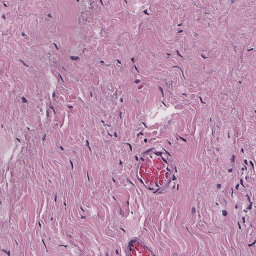

In [22]:
# Resolution looks the same

wsi.read_region((9000, 10000), 0, (256, 256))

#location (tuple) – (x, y) tuple giving the top left pixel in the level 0 reference frame
#level (int) – the level number
#size (tuple) – (width, height) tuple giving the region size

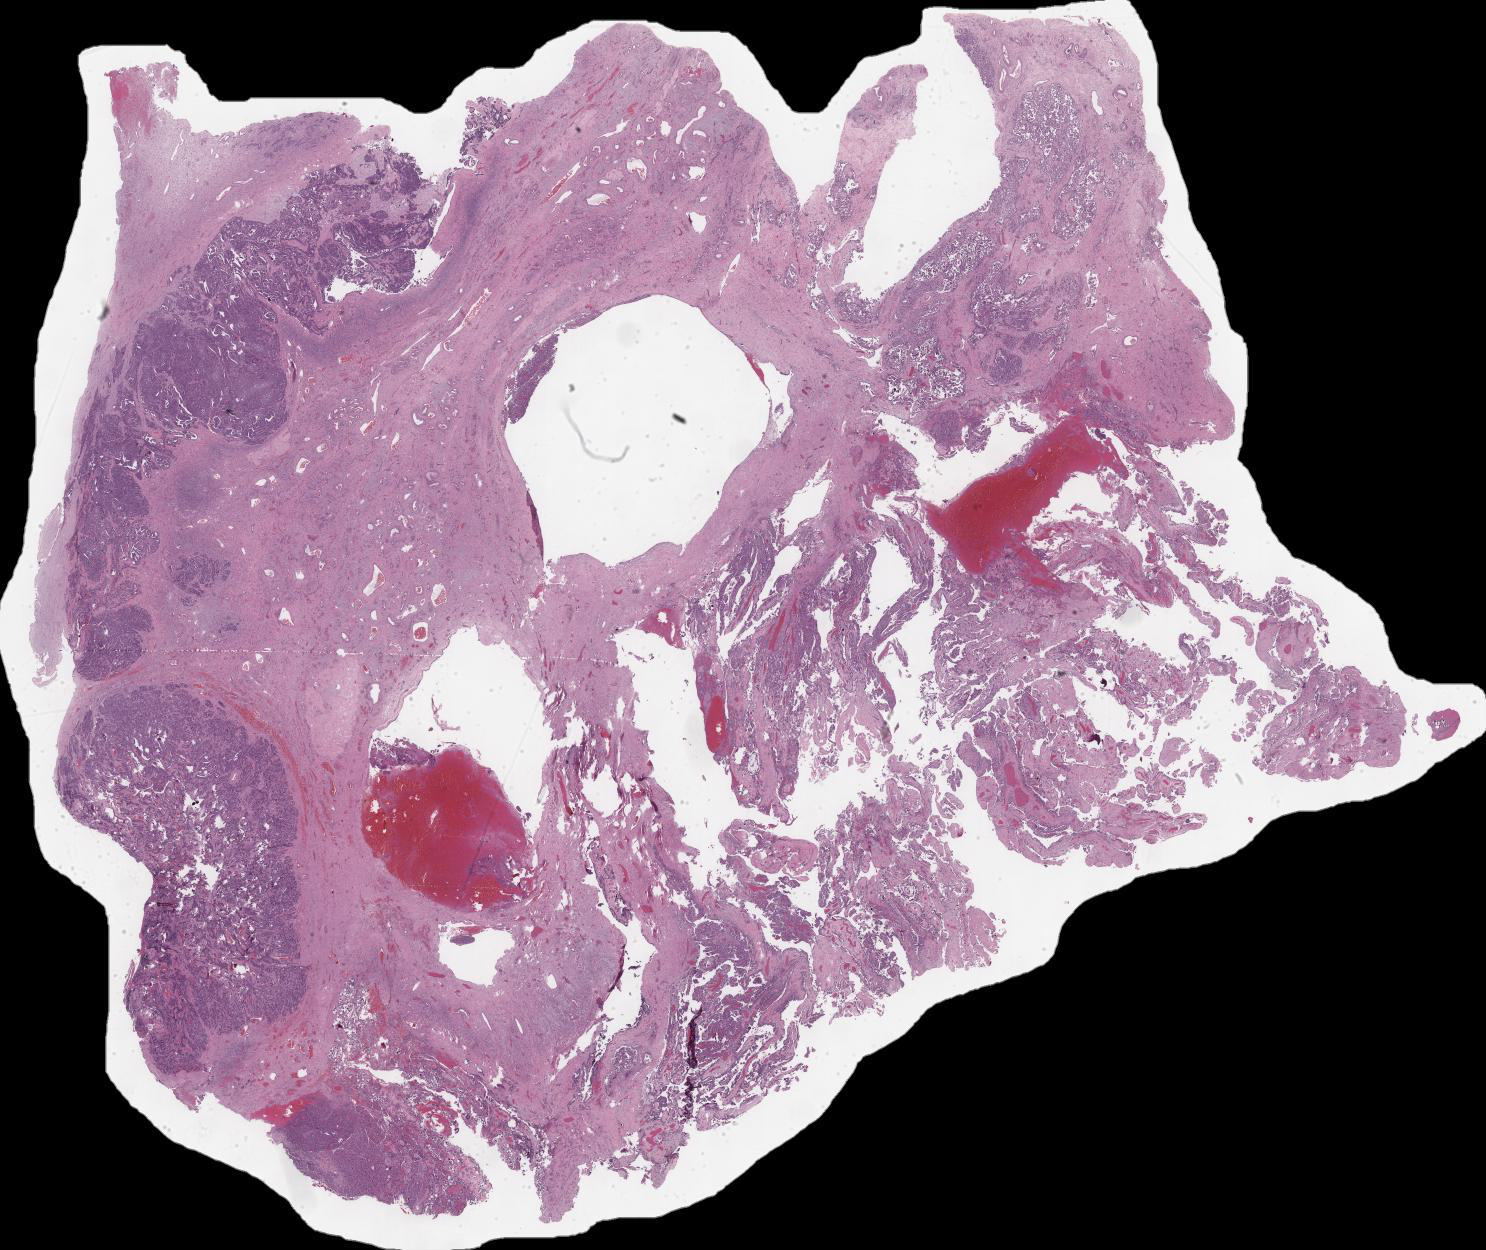

In [15]:
wsi.get_thumbnail(wsi.level_dimensions[-4])

### Analysis
Default tiffsave produces huge GB files. Using JPEG compression reduces file size massively, and resolution seems comparable.

#### Save as jpeg for development, but try saving as bigtiff when running on Kaggle
For Kaggle:
```image.tiffsave(f"___.tif", tile=True, pyramid=True, bigtiff=True, tile_width=256, tile_height=256)```

For development:
```image.tiffsave(f"___.tif", tile=True, pyramid=True, bigtiff=False, compression='jpeg', tile_width=256, tile_height=256)```

Convert and save all png images to tiff

In [ ]:
for png in pnglist:
    if not os.path.exists(f"{png[:-4]}.tif"):
        try:
            image = pyvips.Image.new_from_file(f"{png}")
            if MODE == 'KAGGLE': 
                image.tiffsave(f"{png[:-4]}.tif", tile=True, pyramid=True, bigtiff=True,
                               tile_width=256, tile_height=256)
            elif MODE == 'DEV':
                image.tiffsave(f"{png[:-4]}.tif", tile=True, pyramid=True, bigtiff=False, 
                               compression='jpeg', tile_width=256, tile_height=256)
            else:
                raise Exception(f'Mode {MODE} not found')
            print(f'Saved tif for image {png}')
        except Exception:
            print(f'Couldn\'t save tif for image {png}')